# Explore Exercises

In [33]:
#imports
import re
import unicodedata
import pandas as pd
import nltk

import env as e

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import acquire as a



### 1. Spam Data


* Load the spam data set.


In [2]:
url = e.get_db_url("spam_db")
sql = "SELECT * FROM spam"

df = pd.read_sql(sql, url, index_col="id")
df.head()

label                                               text
id                                                         
0    ham  Go until jurong point, crazy.. Available only ...
1    ham                      Ok lar... Joking wif u oni...
2   spam  Free entry in 2 a wkly comp to win FA Cup fina...
3    ham  U dun say so early hor... U c already then say...
4    ham  Nah I don't think he goes to usf, he lives aro...

In [4]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]


In [6]:
df['clean_text'] = df['text'].apply(clean)

In [7]:
df.head()

label                                               text  \
id                                                            
0    ham  Go until jurong point, crazy.. Available only ...   
1    ham                      Ok lar... Joking wif u oni...   
2   spam  Free entry in 2 a wkly comp to win FA Cup fina...   
3    ham  U dun say so early hor... U c already then say...   
4    ham  Nah I don't think he goes to usf, he lives aro...   

                                           clean_text  
id                                                     
0   [go, jurong, point, crazy, available, bugis, n...  
1                         [ok, lar, joking, wif, oni]  
2   [free, entry, wkly, comp, win, fa, cup, final,...  
3             [dun, say, early, hor, c, already, say]  
4   [nah, dont, think, go, usf, life, around, though]

* Create and explore bigrams for the spam data. Visualize them with a word cloud. How do they compare with the ham bigrams?


In [8]:
labels = pd.concat([df.label.value_counts(),
                    df.label.value_counts(normalize=True)], axis=1)
labels.columns = ['n', 'percent']
labels


n   percent
label                
ham    4825  0.865937
spam    747  0.134063

In [9]:
ham_words = clean(' '.join(df[df.label == 'ham'].text))
spam_words = clean(' '.join(df[df.label == 'spam'].text))
all_words = clean(' '.join(df.text))


In [10]:
ham_freq = pd.Series(ham_words).value_counts()
spam_freq = pd.Series(spam_words).value_counts()
all_freq = pd.Series(all_words).value_counts()

spam_freq.head()


call    359
free    216
txt     150
ur      144
text    137
Name: count, dtype: int64

In [11]:
word_counts = (pd.concat([all_freq, ham_freq, spam_freq], axis=1, sort=True)
                .set_axis(['all', 'ham', 'spam'], axis=1)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()


all  ham  spam
0               3    0     3
008704050406    2    0     2
0089my          1    0     1
0121            1    0     1
01223585236     1    0     1

In [12]:
word_counts.sort_values(by='all', ascending=False).head(10)


all  ham  spam
call  600  241   359
im    462  449    13
get   397  314    83
ur    384  240   144
go    304  273    31
4     287  168   119
dont  279  257    22
ok    277  272     5
free  275   59   216
know  267  241    26

In [13]:
pd.concat([word_counts[word_counts.spam == 0].sort_values(by='ham').tail(6),
           word_counts[word_counts.ham == 0].sort_values(by='spam').tail(6)])


all  ham  spam
thats        94   94     0
i_          117  117     0
say         118  118     0
da          132  132     0
later       134  134     0
lor         160  160     0
awarded      38    0    38
18           43    0    43
guaranteed   50    0    50
tone         73    0    73
prize        94    0    94
claim       115    0   115

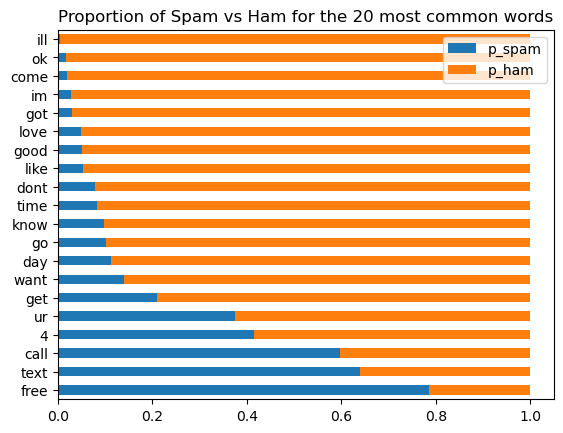

In [16]:
# figure out the percentage of spam vs ham
(word_counts
 .assign(p_spam=word_counts.spam / word_counts['all'],
         p_ham=word_counts.ham / word_counts['all'])
 .sort_values(by='all')
 [['p_spam', 'p_ham']]
 .tail(20)
 .sort_values('p_ham')
 .plot.barh(stacked=True))

plt.title('Proportion of Spam vs Ham for the 20 most common words')
plt.show()


In [18]:
from wordcloud import WordCloud

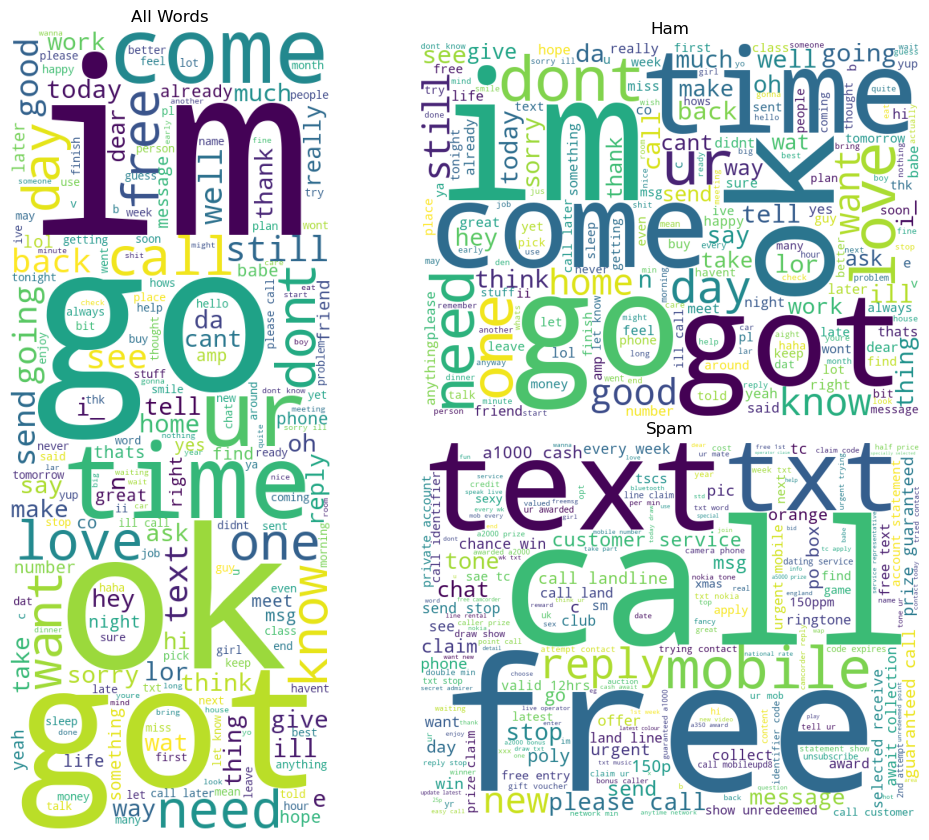

In [19]:
all_cloud = WordCloud(background_color='white', height=1000, width=400).generate(' '.join(all_words))
ham_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(ham_words))
spam_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(spam_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, 0, .5, 1]), plt.axes([.5, .5, .5, .5]), plt.axes([.5, 0, .5, .5])]

axs[0].imshow(all_cloud)
axs[1].imshow(ham_cloud)
axs[2].imshow(spam_cloud)

axs[0].set_title('All Words')
axs[1].set_title('Ham')
axs[2].set_title('Spam')

for ax in axs: ax.axis('off')


* Is there any overlap in the bigrams for the spam data and the ham data?


In [20]:
top_20_ham_bigrams = (pd.Series(nltk.ngrams(ham_words, 2))
                      .value_counts()
                      .head(20))

top_20_ham_bigrams.head()


(call, later)    52
(ill, call)      48
(let, know)      42
(sorry, ill)     39
(dont, know)     32
Name: count, dtype: int64

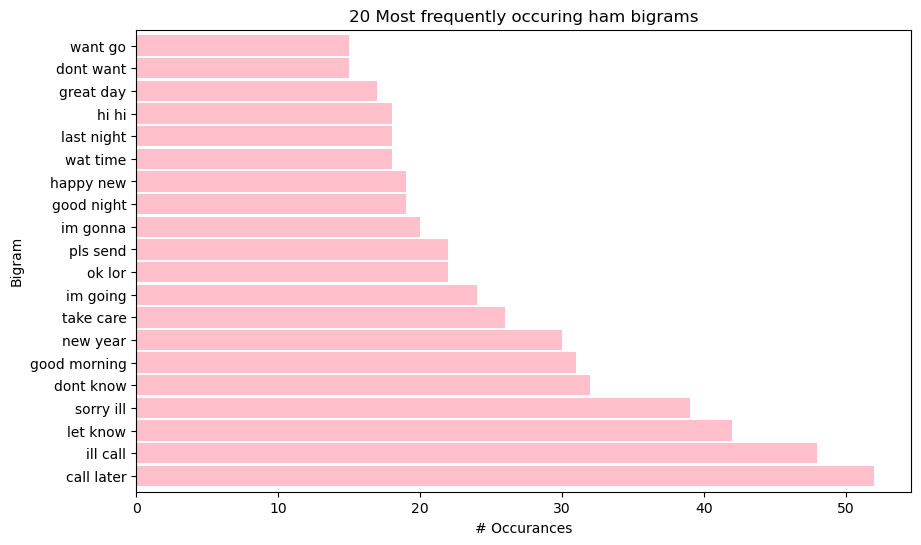

In [21]:
top_20_ham_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ham bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ham_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


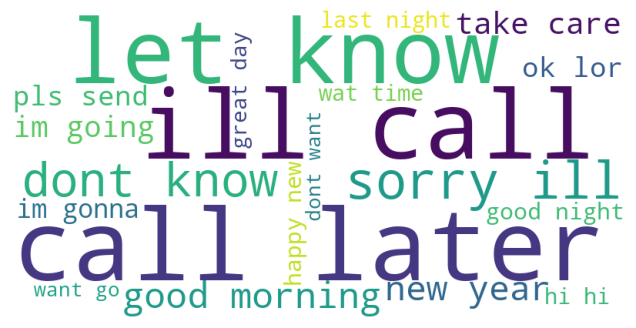

In [22]:
# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.


data = {k[0] + ' ' + k[1]: v for k, v in top_20_ham_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()


In [23]:
top_20_spam_bigrams = (pd.Series(nltk.ngrams(spam_words, 2))
                      .value_counts()
                      .head(20))

top_20_spam_bigrams.head()


(please, call)         44
(customer, service)    27
(po, box)              24
(a1000, cash)          23
(guaranteed, call)     23
Name: count, dtype: int64

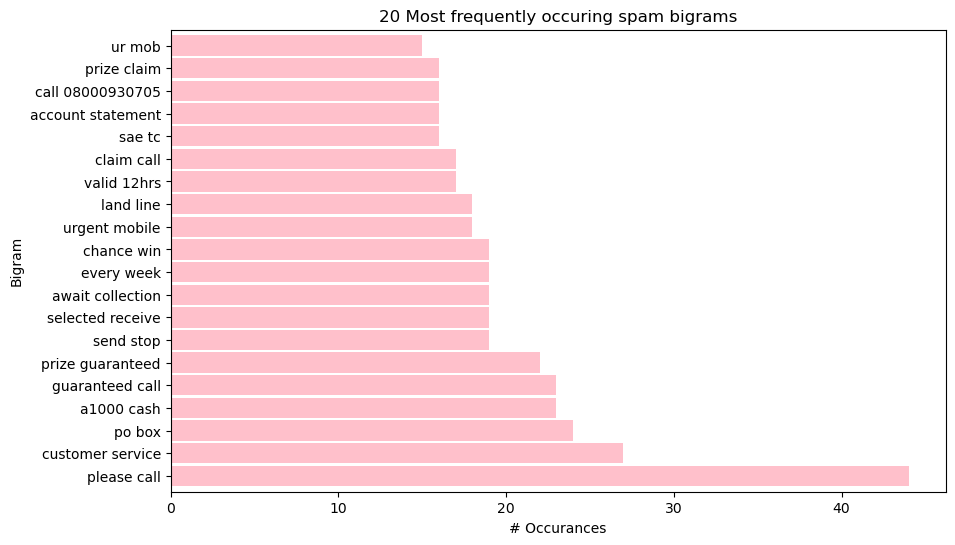

In [24]:
top_20_spam_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring spam bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_spam_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


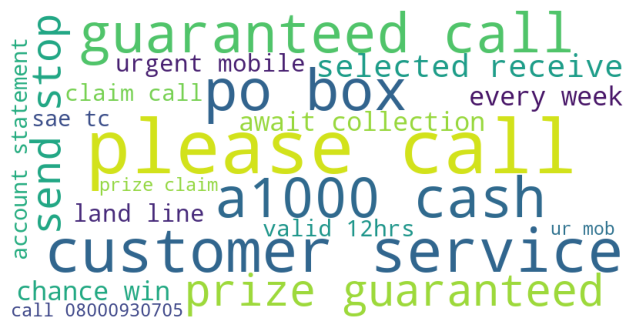

In [25]:
# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.


data = {k[0] + ' ' + k[1]: v for k, v in top_20_spam_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()


* Create and explore with trigrams (i.e. a n-gram with an n of 3) for both the spam and ham data.


In [26]:
top_20_ham_trigrams = (pd.Series(nltk.ngrams(ham_words, 3))
                      .value_counts()
                      .head(20))

top_20_ham_trigrams.head()


(ill, call, later)      42
(sorry, ill, call)      38
(happy, new, year)      19
(pls, send, message)    13
(cant, pick, phone)     12
Name: count, dtype: int64

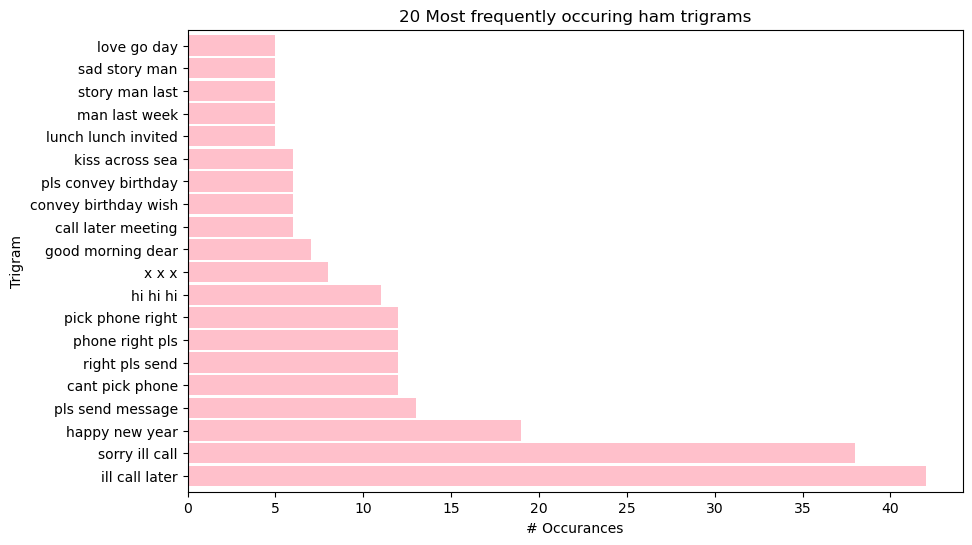

In [28]:
top_20_ham_trigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring ham trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_ham_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)


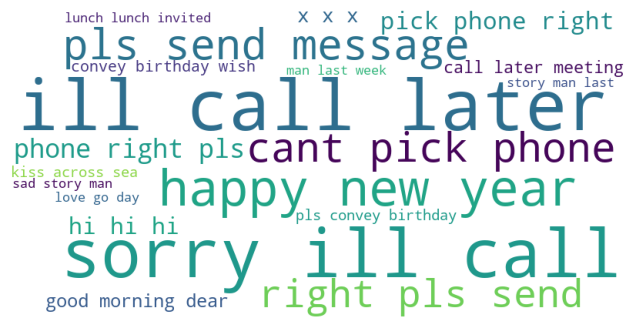

In [29]:
# We can supply our own values to be used to determine how big the words (or
# phrases) should be through the `generate_from_frequencies` method. The
# supplied values must be in the form of a dictionary where the keys are the
# words (phrases), and the values are numbers that correspond to the sizes.
#
# We'll convert our series to a dictionary, and convert the tuples that make up
# the index into a single string that holds each phrase.


data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_ham_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()


In [30]:
top_20_spam_trigrams = (pd.Series(nltk.ngrams(spam_words, 3))
                      .value_counts()
                      .head(20))

top_20_spam_trigrams.head()

(prize, guaranteed, call)     21
(call, customer, service)     15
(land, line, claim)           14
(reply, call, 08000930705)    14
(private, 2003, account)      13
Name: count, dtype: int64

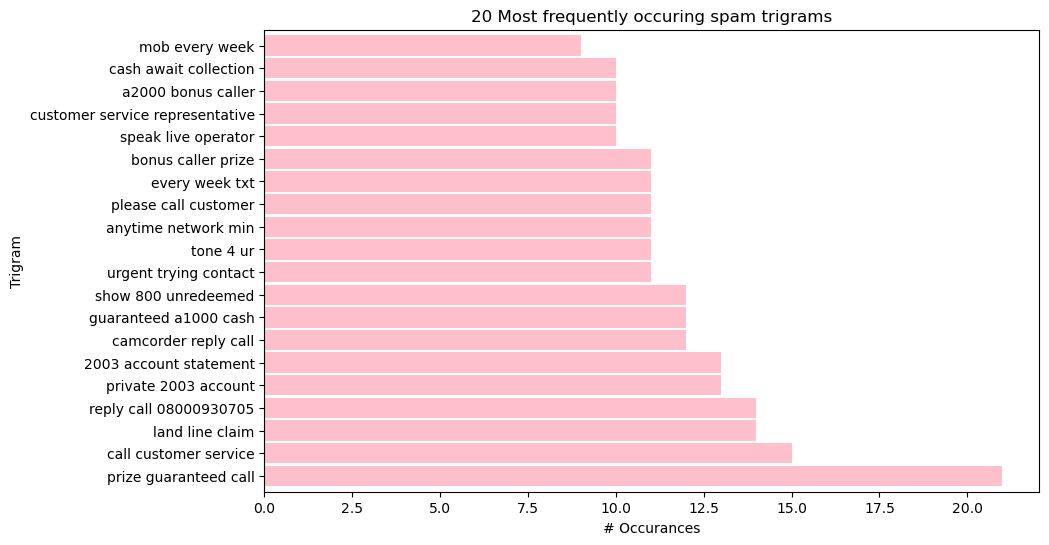

In [31]:
top_20_spam_trigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring spam trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_spam_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

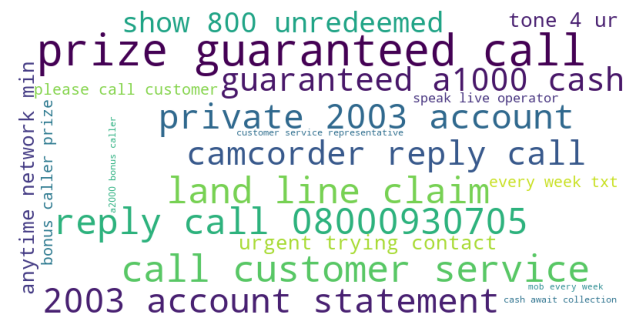

In [32]:



data = {k[0] + ' ' + k[1] + ' ' + k[2]: v for k, v in top_20_spam_trigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

### 2. Explore the blog articles using the techniques discussed in the exploration lesson.


### 3. Explore the news articles using the techniques discussed in the exploration lesson. Use the category variable when exploring.

In [34]:
news_df = a.acquire_news_articles()

In [35]:
news_df.head()

title  \
0  Jet Airways Founder Naresh Goyal allowed home ...   
1  Wipro's staff count falls for 4th quarter, att...   
2  Wipro's revenue in Q2 falls to ₹22,516 cr, pro...   
3  Will march them off to Tihar, they'll know SC'...   
4  Goldman Sachs CEO David Solomon quits working ...   

                                                body  category  
0  A special PMLA court in Mumbai has allowed Jet...  business  
1  Wipro reported a fall in its employee headcoun...  business  
2  IT major Wipro reported a 0.1% fall in its rev...  business  
3  Chief Justice of India (CJI) DY Chandrachud re...  business  
4  David Solomon, the 61-year-old CEO of investme...  business

In [42]:


def clean(text):
    'A simple function to cleanup text data'
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') 
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]

In [38]:
def show_counts_and_ratios(df, column):
    """
    Takes in a dataframe and a string of a single column
    Returns a dataframe with absolute value counts and percentage value counts
    """
    labels = pd.concat([df[column].value_counts(),
                    df[column].value_counts(normalize=True)], axis=1)
    labels.columns = ['n', 'percent']
    labels
    return labels

show_counts_and_ratios(df, "label")


n   percent
label                
ham    4825  0.865937
spam    747  0.134063

In [39]:
show_counts_and_ratios(news_df, 'category')

n  percent
category                  
business       10     0.25
sports         10     0.25
technology     10     0.25
entertainment  10     0.25

In [44]:
news_df.head()

title  \
0  Jet Airways Founder Naresh Goyal allowed home ...   
1  Wipro's staff count falls for 4th quarter, att...   
2  Wipro's revenue in Q2 falls to ₹22,516 cr, pro...   
3  Will march them off to Tihar, they'll know SC'...   
4  Goldman Sachs CEO David Solomon quits working ...   

                                                body  category  
0  A special PMLA court in Mumbai has allowed Jet...  business  
1  Wipro reported a fall in its employee headcoun...  business  
2  IT major Wipro reported a 0.1% fall in its rev...  business  
3  Chief Justice of India (CJI) DY Chandrachud re...  business  
4  David Solomon, the 61-year-old CEO of investme...  business

In [45]:
business_words = clean(' '.join(news_df[news_df.category == 'business'].body))
sport_words = clean(' '.join(news_df[news_df.category == 'sports'].body))
tech_words = clean(' '.join(news_df[news_df.category == 'technology'].body))
enter_words = clean(' '.join(news_df[news_df.category == 'entertainment'].body))
all_words = clean(' '.join(news_df.body))


In [49]:
business_words[:10]

['special',
 'pmla',
 'court',
 'mumbai',
 'allowed',
 'jet',
 'airway',
 'founder',
 'naresh',
 'goyal']

In [46]:
business_freq = pd.Series(business_words).value_counts()
sport_freq = pd.Series(sport_words).value_counts()
tech_freq = pd.Series(tech_words).value_counts()
enter_freq = pd.Series(enter_words).value_counts()

all_freq = pd.Series(all_words).value_counts()



In [47]:
business_freq.head()

crore       7
reported    6
said        6
2023        5
employee    5
Name: count, dtype: int64

In [50]:
word_counts = (pd.concat([all_freq, business_freq, sport_freq, tech_freq, enter_freq], axis=1, sort=True)
                .set_axis(['all', 'business', 'sport', 'tech', 'entertainment'], axis=1)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()


all  business  sport  tech  entertainment
01      2         1      0     1              0
1       5         2      0     3              0
1000    1         1      0     0              0
1012    1         0      0     0              1
10th    1         0      0     1              0

In [51]:
word_counts.sort_values(by='all', ascending=False).head(10)


all  business  sport  tech  entertainment
said       23         6      4     6              7
2023       15         5      5     5              0
india      14         3      8     2              1
added      11         1      5     1              4
crore      11         7      0     4              0
reported   11         6      0     5              0
world      11         1      9     1              0
cup         9         0      9     0              0
new         9         1      2     6              0
employee    9         5      0     4              0

In [52]:
pd.concat([word_counts[word_counts.business == 0].sort_values(by='business').tail(6),
           word_counts[word_counts.sport == 0].sort_values(by='sport').tail(6),
           word_counts[word_counts.tech == 0].sort_values(by='tech').tail(6),
           word_counts[word_counts.entertainment == 0].sort_values(by='entertainment').tail(6)])


all  business  sport  tech  entertainment
exploring      1         0      0     1              0
expressway     1         0      1     0              0
exuded         1         0      0     0              1
eye            1         0      0     0              1
failure        1         0      0     1              0
zoom           3         0      0     3              0
djing          2         2      0     0              0
drunk          1         0      0     0              1
dy             1         1      0     0              0
early          3         1      0     1              1
display        1         0      0     1              0
zoom           3         0      0     3              0
drunk          1         0      0     0              1
dutee          1         0      1     0              0
dy             1         1      0     0              0
easy           1         0      1     0              0
different      1         0      0     0              1
zainab         1         0      1     0              0
dutee          1         0      1     0              0
dy             1         1      0     0              0
easy           1         0      1     0              0
electronics    1         0      0     1              0
djing          2         2      0     0              0
zoom           3         0      0     3              0

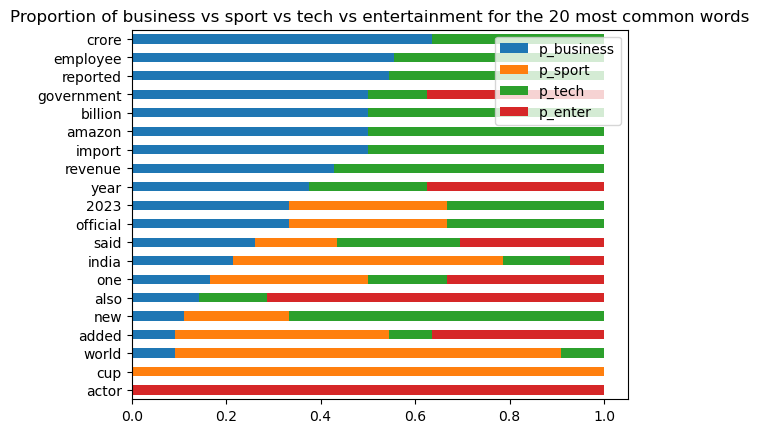

In [54]:
# figure out the percentage of business vs sport vs tech vs entertainment
(word_counts
 .assign(p_business=word_counts.business / word_counts['all'],
         p_sport=word_counts.sport / word_counts['all'],
         p_tech=word_counts.tech / word_counts['all'],
         p_enter=word_counts.entertainment / word_counts['all'])
 .sort_values(by='all')
 [['p_business', 'p_sport', 'p_tech', 'p_enter']]
 .tail(20)
 .sort_values('p_business')
 .plot.barh(stacked=True))

plt.title('Proportion of business vs sport vs tech vs entertainment for the 20 most common words')
plt.show()


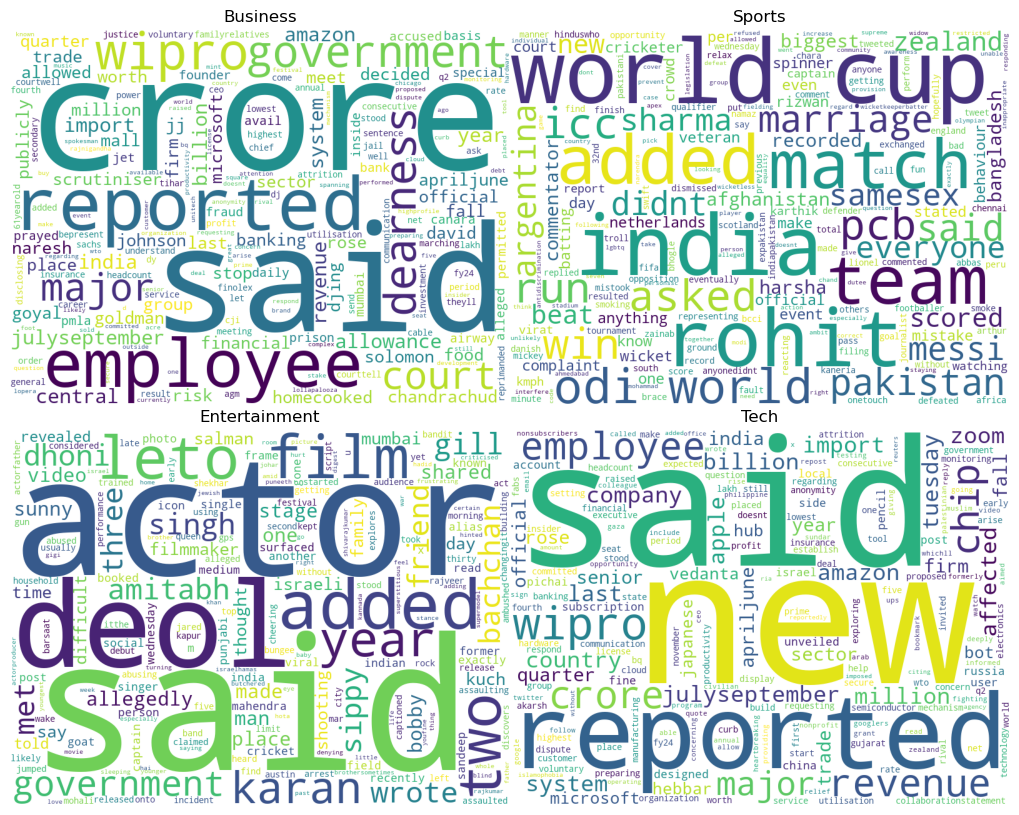

In [59]:
# all_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(all_words))
business_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(business_words))
sport_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(sport_words))
tech_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(tech_words))
enter_cloud = WordCloud(background_color='white', height=600, width=800).generate(' '.join(enter_words))

plt.figure(figsize=(10, 8))
axs = [plt.axes([0, .5, .5, .5]), plt.axes([.5, .5, .5,.5]), plt.axes([.5, 0, .5, .5]), plt.axes([0, 0, .5, .5])]

axs[0].imshow(business_cloud)
axs[1].imshow(sport_cloud)
axs[2].imshow(tech_cloud)
axs[3].imshow(enter_cloud)

axs[0].set_title('Business')
axs[1].set_title('Sports')
axs[2].set_title('Tech')
axs[3].set_title('Entertainment')

for ax in axs: ax.axis('off')


## Business Bigrams and Trigrams

In [60]:
top_20_bus_bigrams = (pd.Series(nltk.ngrams(business_words, 2))
                      .value_counts()
                      .head(20))

top_20_bus_bigrams.head()


(julyseptember, 2023)    3
(dearness, allowance)    3
(central, government)    3
(1, billion)             2
(publicly, djing)        2
Name: count, dtype: int64

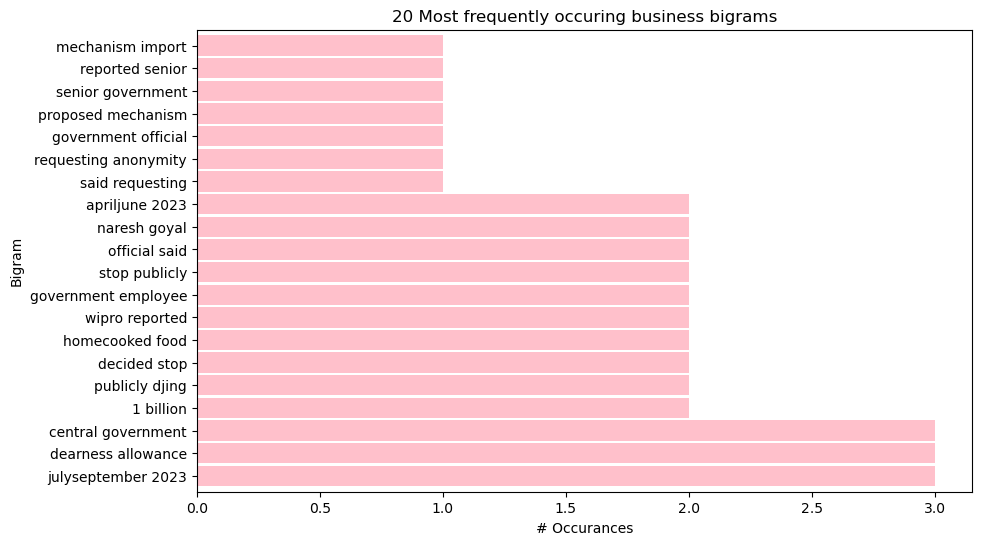

In [62]:
top_20_bus_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring business bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_bus_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


In [61]:
top_20_bus_trigrams = (pd.Series(nltk.ngrams(business_words, 3))
                      .value_counts()
                      .head(20))

top_20_bus_trigrams.head()

(decided, stop, publicly)          2
(central, government, employee)    2
(stop, publicly, djing)            2
(import, bq, prime)                1
(bq, prime, reported)              1
Name: count, dtype: int64

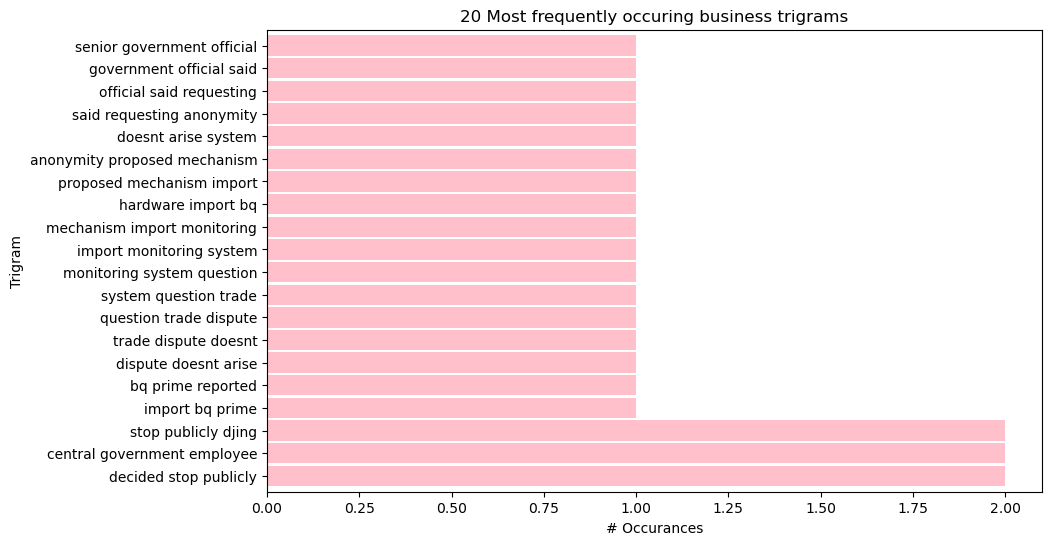

In [63]:
top_20_bus_trigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring business trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_bus_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

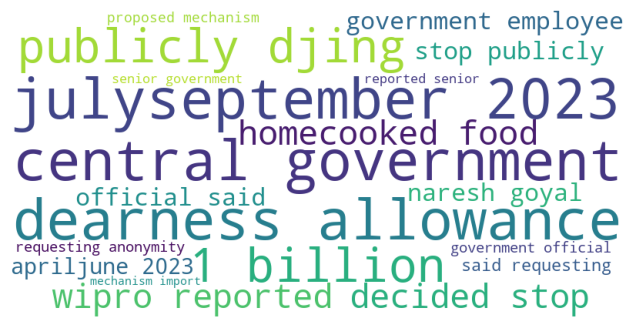

In [76]:



data = {k[0] + ' ' + k[1]: v for k, v in top_20_bus_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()


## Sports Bigrams and Trigrams

In [64]:
top_20_sport_bigrams = (pd.Series(nltk.ngrams(sport_words, 2))
                      .value_counts()
                      .head(20))

top_20_sport_bigrams.head()

(world, cup)           9
(cup, 2023)            5
(odi, world)           5
(rohit, sharma)        3
(marriage, samesex)    2
Name: count, dtype: int64

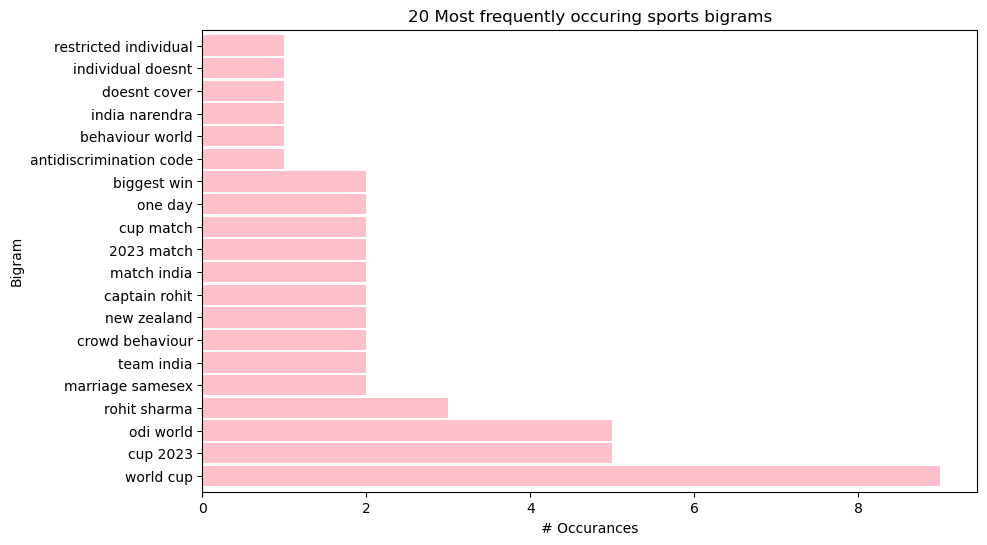

In [65]:
top_20_sport_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring sports bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_sport_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


In [66]:
top_20_sport_trigrams = (pd.Series(nltk.ngrams(sport_words, 3))
                      .value_counts()
                      .head(20))

top_20_sport_trigrams.head()

(odi, world, cup)           5
(world, cup, 2023)          5
(cup, 2023, match)          2
(world, cup, match)         2
(captain, rohit, sharma)    2
Name: count, dtype: int64

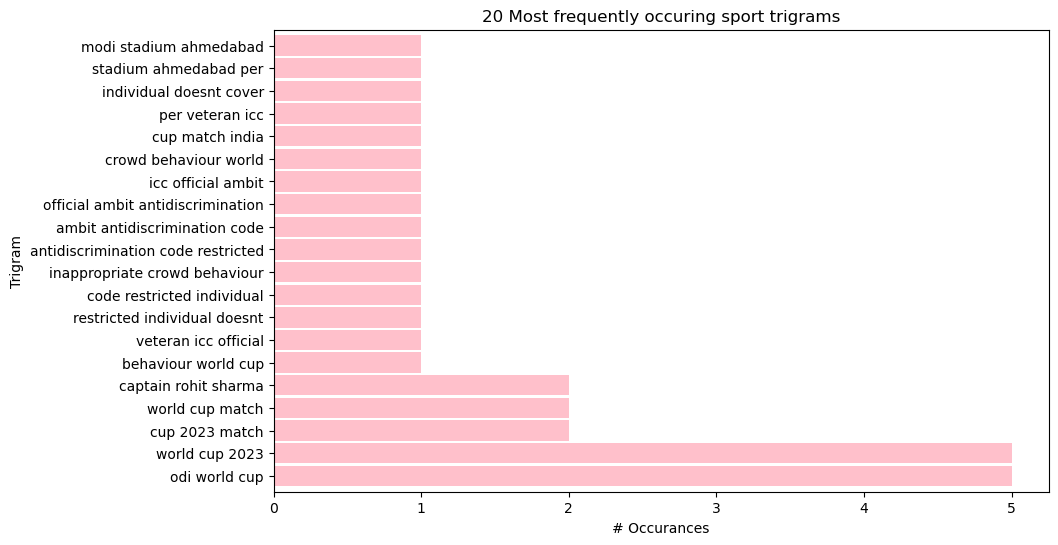

In [67]:
top_20_sport_trigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring sport trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_sport_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

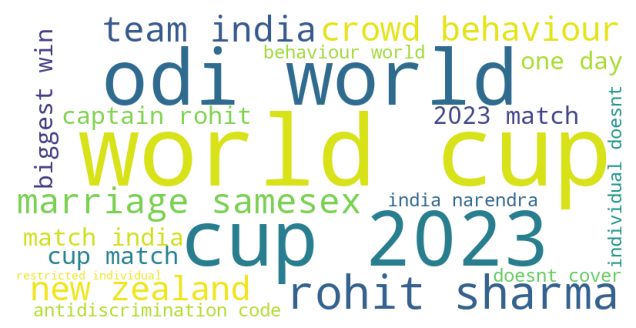

In [77]:



data = {k[0] + ' ' + k[1]: v for k, v in top_20_sport_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()


## Tech Bigrams and Trigrams

In [68]:
    


top_20_tech_bigrams = (pd.Series(nltk.ngrams(tech_words, 2))
                    .value_counts()
                    .head(20))
top_20_tech_bigrams.head()

(julyseptember, 2023)    3
(wipro, reported)        2
(official, said)         2
(1, billion)             2
(apriljune, 2023)        2
Name: count, dtype: int64

In [69]:
top_20_tech_trigrams = (pd.Series(nltk.ngrams(tech_words, 3))
                    .value_counts()
                    .head(20))
top_20_tech_trigrams.head()


(new, apple, pencil)          2
(wipro, reported, fall)       1
(colleague, israel, going)    1
(muslim, googlers, deeply)    1
(arab, muslim, googlers)      1
Name: count, dtype: int64

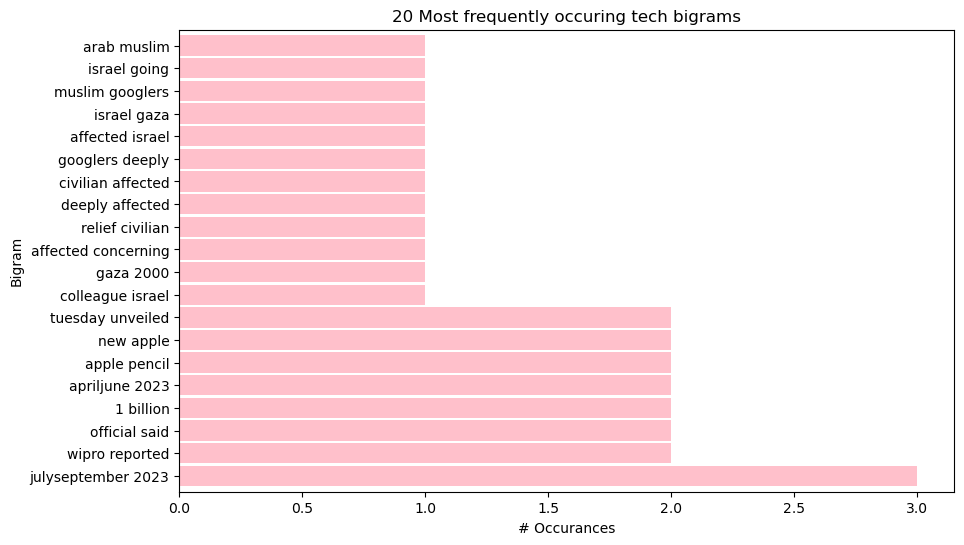

In [70]:
top_20_tech_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring tech bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_tech_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


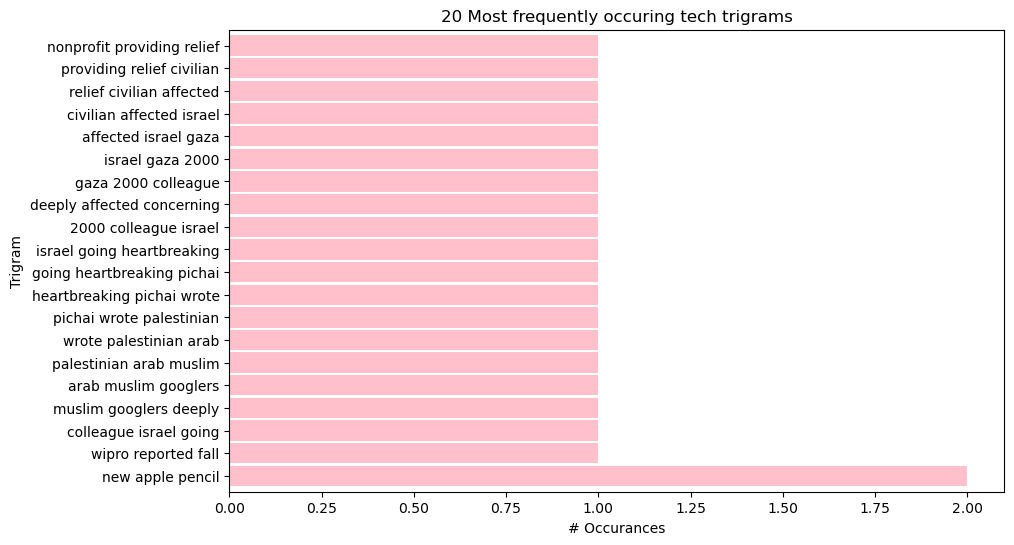

In [71]:
top_20_tech_trigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring tech trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_tech_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

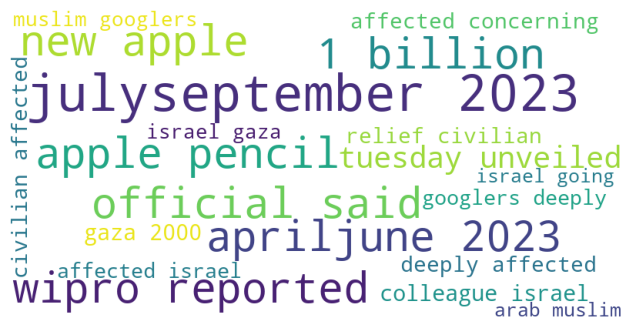

In [78]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_tech_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()

## Enterainment Bigrams and Trigrams

In [72]:
    


top_20_enter_bigrams = (pd.Series(nltk.ngrams(enter_words, 2))
                    .value_counts()
                    .head(20))
top_20_enter_bigrams.head()

(amitabh, bachchan)      2
(also, shared)           2
(also, said)             2
(israeli, government)    2
(whole, family)          1
Name: count, dtype: int64

In [73]:
top_20_enter_trigrams = (pd.Series(nltk.ngrams(enter_words, 3))
                    .value_counts()
                    .head(20))
top_20_enter_trigrams.head()

(amitabh, bachchan, recently)    1
(bachchan, recently, met)        1
(family, difficult, digest)      1
(whole, family, difficult)       1
(difficult, whole, family)       1
Name: count, dtype: int64

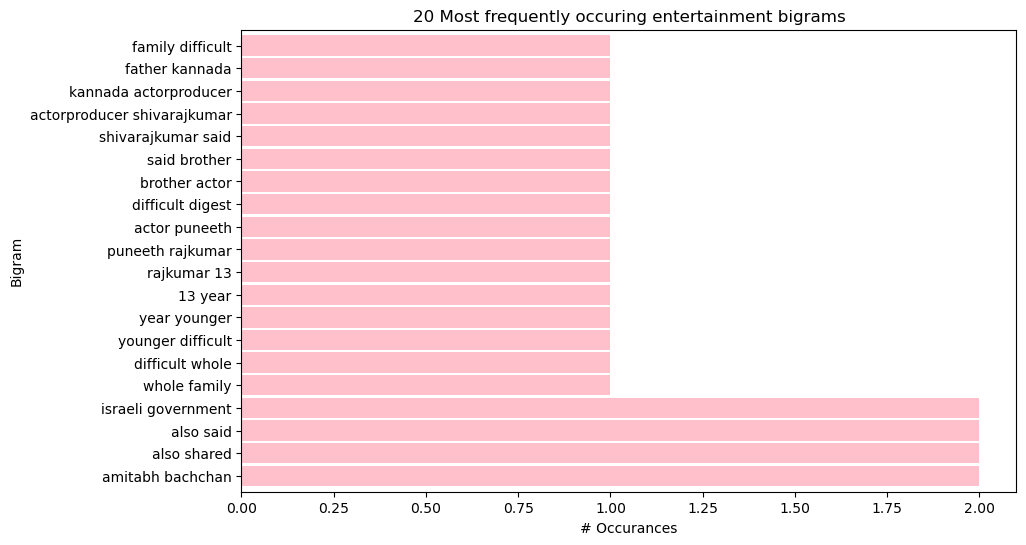

In [74]:
top_20_enter_bigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring entertainment bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_enter_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)


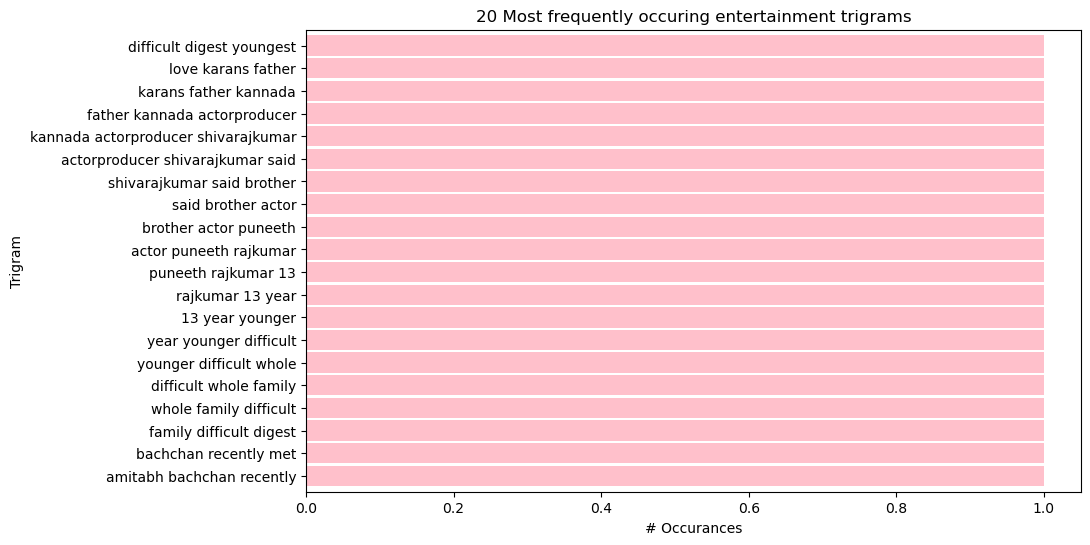

In [75]:
top_20_enter_trigrams.sort_values(ascending=False).plot.barh(color='pink', width=.9, figsize=(10, 6))

plt.title('20 Most frequently occuring entertainment trigrams')
plt.ylabel('Trigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = top_20_enter_trigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1] + ' ' + t[2])
_ = plt.yticks(ticks, labels)

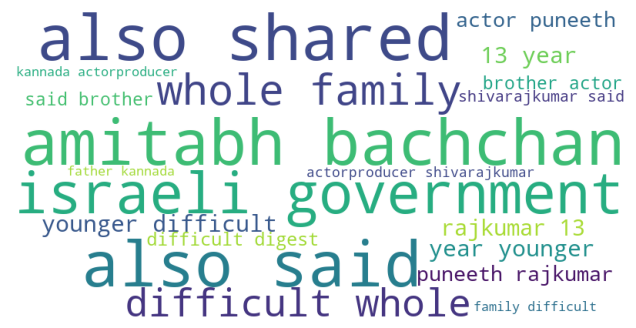

In [79]:
data = {k[0] + ' ' + k[1]: v for k, v in top_20_enter_bigrams.to_dict().items()}
img = WordCloud(background_color='white', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(8, 4))
plt.imshow(img)
plt.axis('off')
plt.show()